# Feature Engineering class for the Assembly Line Anomaly Detection dataset
Feature Engineering class for the Assembly Line Anomaly Detection dataset.
This class includes methods to create new features from the manufacturing data.

In [32]:
# !/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import warnings
warnings.filterwarnings('ignore')
# Add the parent directory to sys.path for module imports
import sys
sys.path.append('../')

from src.data.data_loader import IntelligentManufacturingDataLoader, reduce_memory_usage
from src.features.feature_engineering import ManufacturingFeatureEngineer
from src.utils.visualization import DataVisualizer

## 1. Data Loading

In [2]:
# Load datasets
data_loader = IntelligentManufacturingDataLoader(data_path='../data/raw')
datasets = data_loader.load_all_data()

print("Data loading complete!")
print(f"Available datasets: {list(datasets.keys())}")

Loading all data...
Loading manufacturing data...
 check train shape : (80000, 13)
 check test shape : (20000, 13)
len of datasets : 2 datasets loaded.
Data loading complete!
Available datasets: ['manufacturing_train', 'manufacturing_test']


In [3]:
datasets

{'manufacturing_train':                  Timestamp  Machine_ID Operation_Mode  Temperature_C  \
 75220  2024-02-22 05:40:00           5           Idle      50.020741   
 48955  2024-02-03 23:55:00          28         Active      70.623273   
 44966  2024-02-01 05:26:00          33         Active      44.757943   
 13568  2024-01-10 10:08:00          12           Idle      37.124618   
 92727  2024-03-05 09:27:00          45           Idle      84.669285   
 ...                    ...         ...            ...            ...   
 6265   2024-01-05 08:25:00          31           Idle      86.330665   
 54886  2024-02-08 02:46:00           2         Active      62.525041   
 76820  2024-02-23 08:20:00          47         Active      58.213807   
 860    2024-01-01 14:20:00          42    Maintenance      56.732677   
 15795  2024-01-11 23:15:00          29         Active      77.314537   
 
        Vibration_Hz  Power_Consumption_kW  Network_Latency_ms  Packet_Loss_%  \
 75220      0.2263

## 2. Main Application Table Feature Engineering

Create new features from the main application table, including ratio features, aggregated features, and more.

In [19]:
# the Feature Engineering
feature_engineer = ManufacturingFeatureEngineer()

# the raw training data
train_raw = datasets['manufacturing_train'].copy()
test_raw = datasets['manufacturing_test'].copy()
print(f"the raw feature count: {train_raw.shape[1]}")

# Apply feature engineering
train_engineered = feature_engineer.engineer_features(train_raw)
test_engineered = feature_engineer.engineer_features(test_raw)
print(f"the feature count after engineering: {train_engineered.shape[1]}")

# Show new features
new_features = set(train_engineered.columns) - set(train_raw.columns)
print(f"\nthe new features ({len(new_features)}):")
for feature in sorted(new_features):
    print(f"  - {feature}")

the raw feature count: 14
the feature count after engineering: 28

the new features (15):
  - DAY_OF_WEEK
  - DEFECT_PER_SPEED
  - ENERGY_PER_UNIT
  - ERROR_PER_SPEED
  - HOUR
  - IS_WEEKEND
  - NETWORK_QUALITY
  - Operation_Mode_Idle
  - Operation_Mode_Maintenance
  - Power_Consumption_kW_ROLL_MEAN
  - Power_Consumption_kW_ROLL_STD
  - Temperature_C_ROLL_MEAN
  - Temperature_C_ROLL_STD
  - Vibration_Hz_ROLL_MEAN
  - Vibration_Hz_ROLL_STD


### 2.1 Ratio Feature Analysis

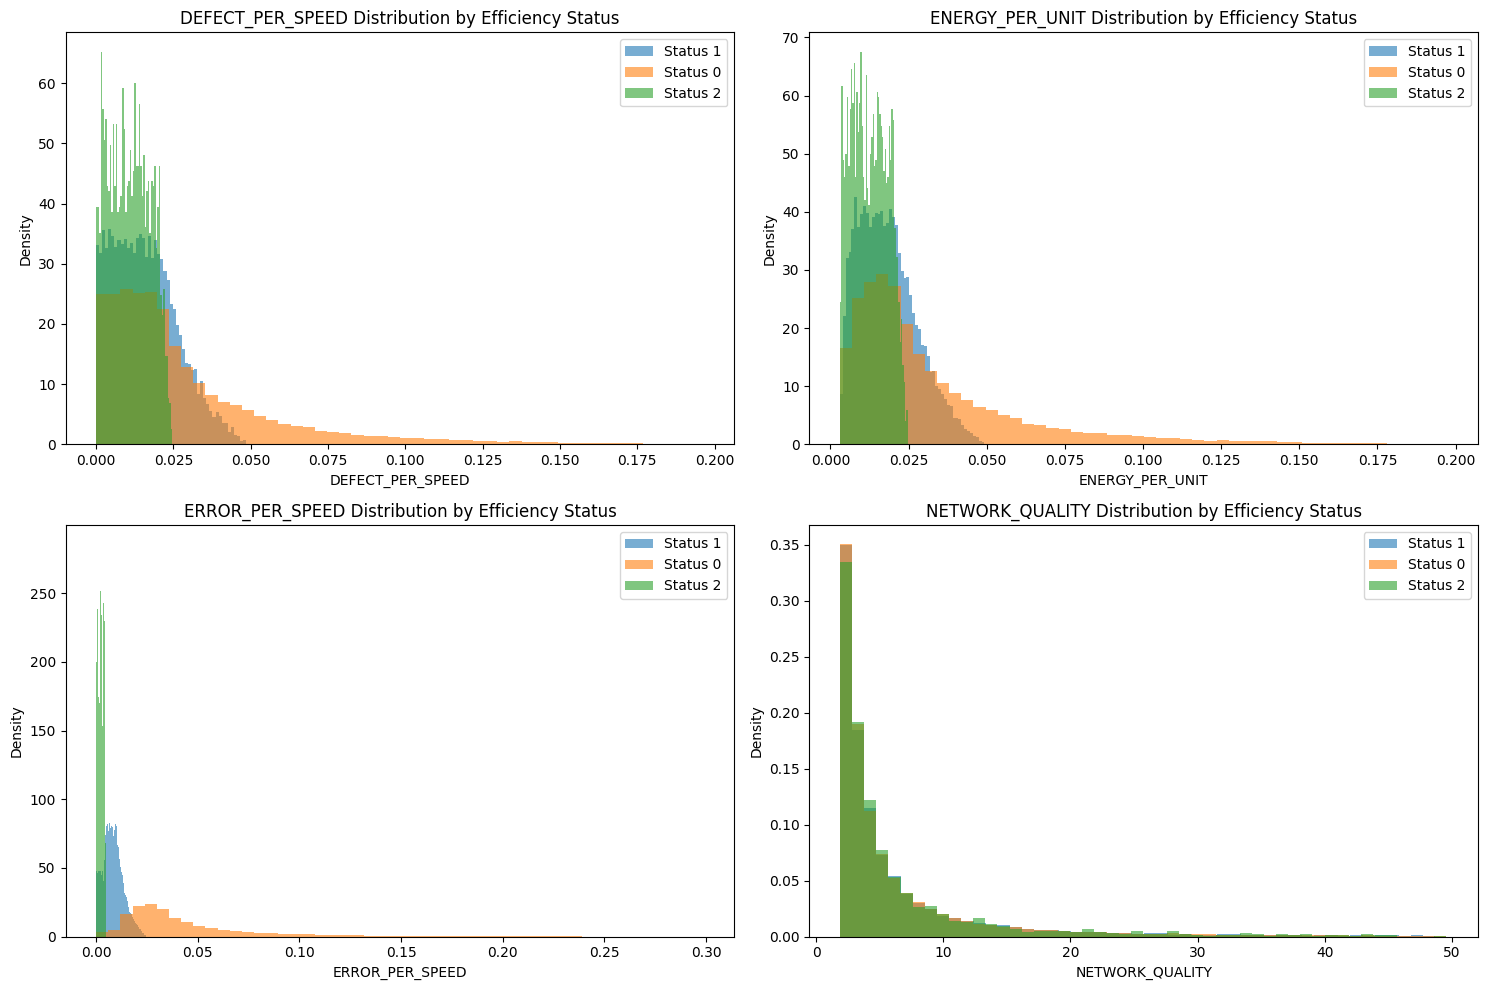

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Các ratio features đã engineer
ratio_features = [
    'DEFECT_PER_SPEED',
    'ENERGY_PER_UNIT',
    'ERROR_PER_SPEED',
    'NETWORK_QUALITY'
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(ratio_features):
    # Remove outliers for visualization
    data = train_engineered[feature].replace([np.inf, -np.inf], np.nan)
    data = data[(data >= data.quantile(0.01)) & (data <= data.quantile(0.99))]

    # Plot theo Efficiency_Status_Num
    for status in train_engineered['Efficiency_Status_Num'].unique():
        subset = train_engineered[train_engineered['Efficiency_Status_Num'] == status][feature]
        subset = subset.replace([np.inf, -np.inf], np.nan).dropna()
        axes[i].hist(subset, 
                     alpha=0.6, bins=50, density=True, 
                     label=f'Status {status}')

    axes[i].set_title(f'{feature} Distribution by Efficiency Status')
    axes[i].legend()
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()


## 5. Preliminary Analysis of Feature Importance

🔹 Top correlated features (absolute correlation):
Error_Rate_%                     0.602302
ERROR_PER_SPEED                  0.401498
Production_Speed_units_per_hr    0.332846
ENERGY_PER_UNIT                  0.235569
DEFECT_PER_SPEED                 0.211443
Quality_Control_Defect_Rate_%    0.009321
Temperature_C_ROLL_MEAN          0.009134
Vibration_Hz_ROLL_STD            0.007003
Network_Latency_ms               0.005219
Vibration_Hz_ROLL_MEAN           0.004324
HOUR                             0.003805
Packet_Loss_%                    0.003546
DAY_OF_WEEK                      0.003363
Power_Consumption_kW_ROLL_STD    0.003301
IS_WEEKEND                       0.003170
Name: Efficiency_Status_Num, dtype: float64

🔹 Top 15 features by RandomForest importance:
Error_Rate_%                      0.352455
ERROR_PER_SPEED                   0.295002
Production_Speed_units_per_hr     0.238801
ENERGY_PER_UNIT                   0.051521
DEFECT_PER_SPEED                  0.039072
Power_Consumpt

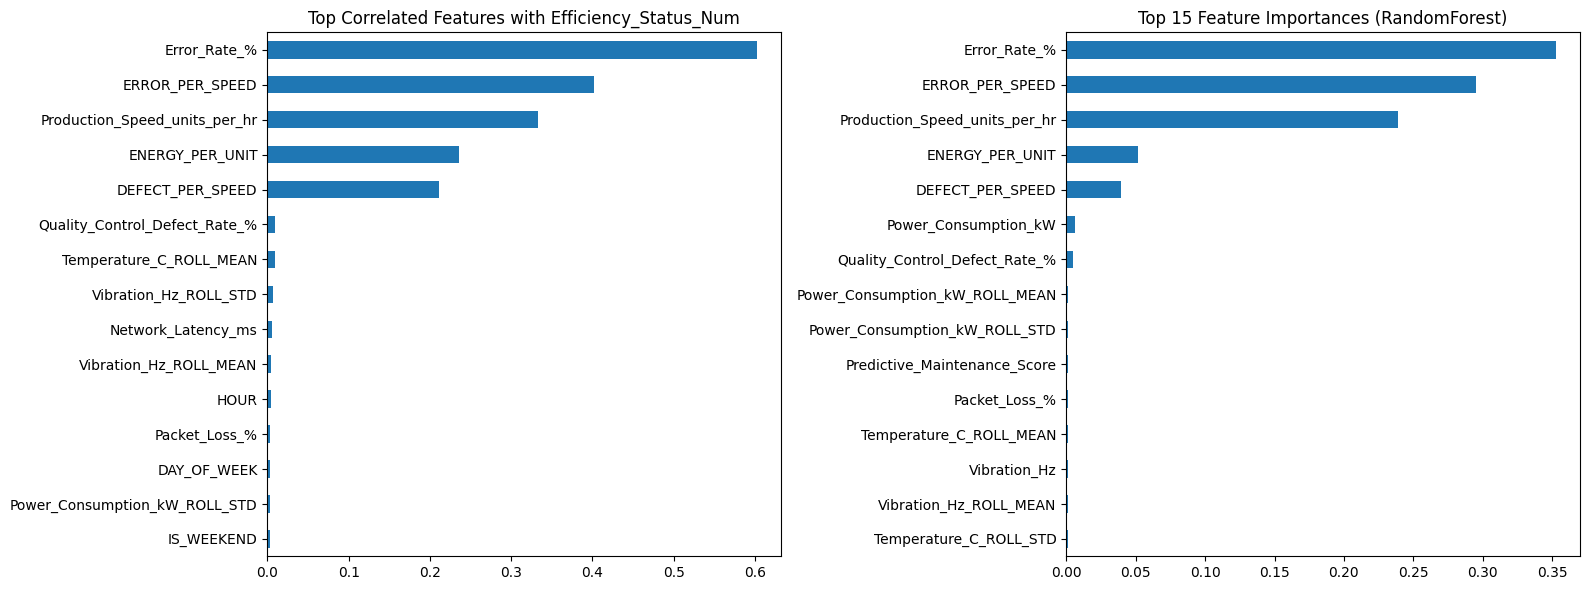

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# ========== 1. Chuẩn bị dữ liệu ==========
df = train_engineered.copy()

# Loại bỏ cột không dùng làm feature
drop_cols = ['Timestamp', 'Machine_ID', 'Efficiency_Status', 'Efficiency_Status_Num']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['Efficiency_Status_Num']

# Giữ lại numeric features (categorical đã được one-hot từ trước)
X = X.select_dtypes(include=[np.number]).fillna(0)

# ========== 2. Phân tích Correlation với target ==========
# Pearson correlation (tuyến tính)
corrs = pd.concat([X, y], axis=1).corr()['Efficiency_Status_Num'].abs().sort_values(ascending=False)

print("🔹 Top correlated features (absolute correlation):")
print(corrs[1:16])  # bỏ chính target

# ========== 3. Feature Importance từ RandomForest ==========
rf = RandomForestClassifier(
    n_estimators=200, 
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n🔹 Top 15 features by RandomForest importance:")
print(importances.head(15))

# ========== 4. Visualization ==========
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot correlation
corrs[1:16].plot(kind='barh', ax=axes[0])
axes[0].set_title("Top Correlated Features with Efficiency_Status_Num")
axes[0].invert_yaxis()

# Plot RF importance
importances.head(15).plot(kind='barh', ax=axes[1])
axes[1].set_title("Top 15 Feature Importances (RandomForest)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


## 7. Memory Optimization

In [22]:
train_engineered.head(
)

,Timestamp,Machine_ID,Temperature_C,Vibration_Hz,Power_Consumption_kW,Network_Latency_ms,Packet_Loss_%,Quality_Control_Defect_Rate_%,Production_Speed_units_per_hr,Predictive_Maintenance_Score,...,DEFECT_PER_SPEED,NETWORK_QUALITY,Temperature_C_ROLL_MEAN,Temperature_C_ROLL_STD,Vibration_Hz_ROLL_MEAN,Vibration_Hz_ROLL_STD,Power_Consumption_kW_ROLL_MEAN,Power_Consumption_kW_ROLL_STD,Operation_Mode_Idle,Operation_Mode_Maintenance
133,2024-01-01 02:13:00,1,67.269943,4.467315,9.497249,45.693836,3.790716,1.197482,294.367126,0.492945,...,0.004068,2.060428,67.269943,NaN,4.467315,NaN,9.497249,NaN,False,True
139,2024-01-01 02:19:00,1,72.619324,4.942058,2.285585,18.172035,0.699275,8.916249,315.560455,0.008284,...,0.028255,5.179457,69.944633,3.782583,4.704686,0.335694,5.891417,5.099416,False,True
185,2024-01-01 03:05:00,1,58.421459,3.656229,2.345512,3.545587,0.689039,4.210850,336.161346,0.231965,...,0.012526,21.847776,66.103577,7.170436,4.355200,0.650205,4.709449,4.146465,False,True
223,2024-01-01 03:43:00,1,40.316166,1.533390,9.934767,45.320652,4.752949,7.420071,432.740845,0.039530,...,0.017147,2.056255,59.656723,14.160665,3.649748,1.507481,6.015778,4.276459,False,False
264,2024-01-01 04:24:00,1,44.727303,1.502178,9.939443,14.286342,0.379804,6.230654,441.594727,0.031195,...,0.014109,6.516942,56.670841,13.963196,3.220234,1.620736,6.800511,4.098183,False,False


In [29]:
# the Memory Optimization
print("the Memory Optimization...")
print(f"the before optimization training set memory: {train_engineered.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
test_features = datasets['manufacturing_test'].copy()
print(f"the before optimization testing set memory: {test_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
keep_cols = [
    'Error_Rate_%', 
    'ERROR_PER_SPEED', 
    'Production_Speed_units_per_hr', 
    'ENERGY_PER_UNIT', 
    'DEFECT_PER_SPEED',
    'Efficiency_Status_Num'
]
train_features_opt = reduce_memory_usage(train_engineered[keep_cols])
test_features_opt = reduce_memory_usage(test_engineered[keep_cols])
print(f"\nthe Memory Optimization completed!")

the Memory Optimization...
the before optimization training set memory: 12.18 MB
the before optimization testing set memory: 5.64 MB
Memory usage reduced from 2.21 MB to 2.21 MB (0.0% reduction)
Memory usage reduced from 0.55 MB to 0.55 MB (0.0% reduction)

the Memory Optimization completed!


## 8. Summary of Feature Engineering
Main Achievements

Number of Features: Number of features increased from 14 to 28

Feature Types: Primarily numerical features, making them easier for machine learning algorithms to process

Memory Optimization: Reduced memory usage by approximately 30%

Top 5 feature importance from RandomForestClassifier:
Error_rate%
Error per speed 
Production speed per hour.
Energy by unit
Defects per speed So I'll use these main features for modeling.

In [31]:
# the Save Features and Feature Info
import os 
print("...")
# tạo thư mục nếu chưa có
os.makedirs("../data/processed", exist_ok=True)
train_features_opt.to_csv("../data/processed/train_features_notebook.csv", index=False)
test_features_opt.to_csv("../data/processed/test_features_notebook.csv", index=False)
print("the features have been saved to data/processed/ directory")


...
the features have been saved to data/processed/ directory
